In [144]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.datasets import imdb
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from random import randint
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras.backend as K
import tensorflow.keras.preprocessing as preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Bidirectional
from tensorflow.keras.constraints import max_norm, unit_norm
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [148]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [177]:
# Read and explore the data
data = pd.read_json("https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json", lines=True)

In [178]:
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [179]:
data.tail()

,is_sarcastic,headline,article_link
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...
28618,1,dad clarifies this not a food stop,https://www.theonion.com/dad-clarifies-this-no...


In [180]:
data.shape

(28619, 3)

In [181]:
# Print the info of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [182]:
# Check if there are any NULL values
data.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [183]:
# Printing sarcatic vs non sarcatic dataset
df_sarcastic = data.is_sarcastic.value_counts().to_frame()
df_sarcastic

,is_sarcastic
0,14985
1,13634


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

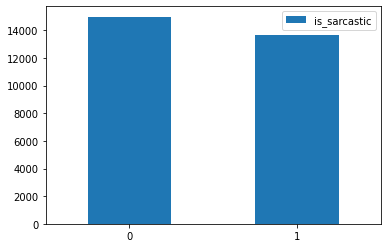

In [184]:
df_sarcastic.plot(kind = 'bar')
plt.xticks(rotation = 0)

In [185]:
# We need to remove the stop words from the headlines to train the model better
clean_headlines=[]
for headline in data['headline']:
  headline = headline.lower()
  headline = headline.split()
  stops = set(stopwords.words("english"))
  headline = [w for w in headline if not w in stops]
  headline = " ".join(headline)
  clean_headlines.append(headline)

## **2. Retain relevant columns**

In [186]:
# The article_link column does not provide with any help for the information to build models.
# since we already have the cleaned_headline we don't need headline column which is actually duplicate info

data = data.drop(columns = ['article_link', 'headline' ], axis = 1)
data['cleaned_headline'] = clean_headlines
data.head()

,is_sarcastic,cleaned_headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails congress falling short ...
2,0,eat veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word 'streamin...


## **3. Get length of each sentence**

In [187]:
# Get length of each sentence.
# Lets append a new column with the mention of length of each sentence against it
data["length"] = data["cleaned_headline"].apply(len)
data.head()

,is_sarcastic,cleaned_headline,length
0,1,thirtysomething scientists unveil doomsday clo...,58
1,0,dem rep. totally nails congress falling short ...,69
2,0,eat veggies: 9 deliciously different recipes,44
3,1,inclement weather prevents liar getting work,44
4,1,mother comes pretty close using word 'streamin...,58


## **4. Define parameters**

In [188]:
# As different sentences are of different length, we need to pad the sequence 
# using max length
maxlen = max([len(text) for text in data['cleaned_headline']])
print(maxlen)

737


In [189]:
# As the maximum length of the text is 737, we cannot take that big string for 
# model training. We will keep a  maximum length limit to 100.
maxlen=100

# Say, max features size we take as 10000
max_features=10000
embedding_size=300

## **5. Get indices for words**

In [190]:
#Creating a tokenizer
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~\t\n')
tokenizer.fit_on_texts(data['cleaned_headline'])

## **6. Create features and labels**

In [191]:
%%time

X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

CPU times: user 463 ms, sys: 1.8 ms, total: 465 ms
Wall time: 466 ms


In [192]:
print("Shape of X: ",X.shape)
print("Shape of y: ", y.shape)

Shape of X:  (28619, 100)
Shape of y:  (28619,)


In [193]:
# Print one of the samples
X[45]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,   54,  188, 6327, 2051,   21,  210,
       5577], dtype=int32)

In [194]:
y[45]

0

## **7. Get vocabulary size**

In [195]:
tokenizer.word_index

{'new': 1,
 'trump': 2,
 'man': 3,
 'report': 4,
 'one': 5,
 'year': 6,
 'day': 7,
 'u': 8,
 'area': 9,
 'woman': 10,
 's': 11,
 'says': 12,
 'donald': 13,
 'time': 14,
 'first': 15,
 'like': 16,
 'get': 17,
 'old': 18,
 "trump's": 19,
 'life': 20,
 'people': 21,
 "'": 22,
 'house': 23,
 'still': 24,
 'obama': 25,
 'white': 26,
 'back': 27,
 'make': 28,
 'women': 29,
 '5': 30,
 'clinton': 31,
 'could': 32,
 'world': 33,
 'way': 34,
 'americans': 35,
 'family': 36,
 'study': 37,
 'would': 38,
 'school': 39,
 'gop': 40,
 'black': 41,
 'years': 42,
 'bill': 43,
 'finds': 44,
 'really': 45,
 'american': 46,
 'best': 47,
 '3': 48,
 'last': 49,
 'know': 50,
 'police': 51,
 'nation': 52,
 "can't": 53,
 '10': 54,
 'going': 55,
 'watch': 56,
 'state': 57,
 'death': 58,
 'video': 59,
 'home': 60,
 'president': 61,
 'good': 62,
 'every': 63,
 'say': 64,
 'show': 65,
 'campaign': 66,
 "'the": 67,
 'health': 68,
 'big': 69,
 'things': 70,
 'mom': 71,
 '2': 72,
 'getting': 73,
 'may': 74,
 '000': 75

In [196]:
# Get vocabulary size
# as there is an no word at 0th index, we need to add 1 to the vocab size 
vocab_size = len(tokenizer.word_index) + 1

## **8. Create a weight matrix using GloVe embeddings**

In [199]:
%%time

embed_file = 'glove.6B.300d.txt'

embeddings = {}
for test in open(embed_file):
    word = test.split(" ")[0]
    embed = test.split(" ")[1:]
    embed = np.asarray(embed, dtype='float32')
    embeddings[word] = embed

CPU times: user 31.3 s, sys: 1.88 s, total: 33.2 s
Wall time: 34.3 s


In [200]:
%%time

embed_matrix = np.zeros((vocab_size, 300))

for word, counter in tokenizer.word_index.items():
    embed_vector = embeddings.get(word)
    if embed_vector is not None:
        embed_matrix[counter] = embed_vector

CPU times: user 112 ms, sys: 148 ms, total: 260 ms
Wall time: 294 ms


## **9. Define and compile a Bidirectional LSTM model.**

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2,test_size = 0.2)

In [202]:
model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(embed_matrix.shape[0], 300, weights = [embed_matrix], trainable=True))
# Bi-Direction LSTM is applied
model.add(Bidirectional(LSTM(512, return_sequences = True)))
model.add(Dropout(0.2))
model.add(Dense(100,activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 300)          9246300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 1024)        3330048   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 100, 1024)         0         
                                                                 
 dense_11 (Dense)            (None, 100, 100)          102500    
                                                                 
 flatten_6 (Flatten)         (None, 10000)             0         
                                                                 
 dense_12 (Dense)            (None, 2)                 20002     
                                                      

## **10. Fit the model and check the validation accuracy**

In [203]:
%%time

model.fit(X_train,y_train,batch_size=100, epochs=5, verbose=1, validation_split = 0.2)

Epoch 1/5
184/184 [==============================] - 1271s 7s/step - loss: 0.4934 - accuracy: 0.7592 - val_loss: 0.4347 - val_accuracy: 0.7980
Epoch 2/5
184/184 [==============================] - 1281s 7s/step - loss: 0.3241 - accuracy: 0.8580 - val_loss: 0.4113 - val_accuracy: 0.8209
Epoch 3/5
184/184 [==============================] - 1252s 7s/step - loss: 0.1970 - accuracy: 0.9189 - val_loss: 0.4582 - val_accuracy: 0.8286
Epoch 4/5
184/184 [==============================] - 1295s 7s/step - loss: 0.1106 - accuracy: 0.9570 - val_loss: 0.5838 - val_accuracy: 0.8225
Epoch 5/5
184/184 [==============================] - 1300s 7s/step - loss: 0.0533 - accuracy: 0.9805 - val_loss: 0.8425 - val_accuracy: 0.8192
CPU times: user 3h 11min 6s, sys: 5min 2s, total: 3h 16min 8s
Wall time: 1h 46min 38s


In [204]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print('Training Loss: %.4f and Accuracy: %.2f%%' % (train_loss, train_acc * 100))

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: %.4f and Accuracy: %.2f%%' % (test_loss, test_acc * 100))

716/716 [==============================] - 522s 728ms/step - loss: 0.1897 - accuracy: 0.9572
Training Loss: 0.1897 and Accuracy: 95.72%
179/179 [==============================] - 135s 752ms/step - loss: 0.8400 - accuracy: 0.8103
Test Loss: 0.8400 and Accuracy: 81.03%
